In [2]:
import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix
import json
import numpy as np
import matplotlib.pyplot as plt

In [31]:
train_dict = load_GO_tsv_file("../data/go_bench/training_molecular_function_annotations.tsv")
val_dict = load_GO_tsv_file("../data/go_bench/validation_molecular_function_annotations.tsv")
test_dict = load_GO_tsv_file("../data/go_bench/testing_molecular_function_annotations.tsv")

In [32]:
from Bio import SeqIO
ps = [(train_dict, []), (val_dict, []), (test_dict, [])]
for rec in SeqIO.parse("../data/uniprot_reviewed.fasta", "fasta"):
    rec.id = rec.id.split("|")[1]
    for d, l in ps:
        if rec.id in d:
            l.append(rec)

In [14]:
with open("../data/prot_train.fasta", "w") as f:
    SeqIO.write(ps[0][1], f, "fasta")
with open("../data/prot_val.fasta", "w") as f:
    SeqIO.write(ps[1][1], f, "fasta")
with open("../data/prot_test.fasta", "w") as f:
    SeqIO.write(ps[2][1], f, "fasta")

In [34]:
sequences, prot_ids = load_protein_sequences("../data/uniprot_reviewed.fasta")
with open("../data/go_bench/molecular_function_terms.json", 'r') as f:
    go_terms = json.load(f)

with open("../data/go_bench/testing_molecular_function_terms.json", 'r') as f:
    test_go_terms = json.load(f)

print(len(go_terms), len(test_go_terms))

train_ids, val_ids, test_ids = list(train_dict.keys()), list(val_dict.keys()), list(test_dict.keys())
train_labels = convert_to_sparse_matrix(train_dict, go_terms, train_ids)
val_labels = convert_to_sparse_matrix(val_dict, go_terms, val_ids)
test_labels = convert_to_sparse_matrix(test_dict, test_go_terms, test_ids)
print(train_labels.shape, val_labels.shape, test_labels.shape)

865 6880
(77671, 865) (16936, 865) (18852, 6880)


In [37]:
def load_diamond_scores(hit_fn):
    diamond_scores = {}
    with open(hit_fn) as f:
        for line in f:
            it = line.strip().split()
            if it[0] not in diamond_scores:
                diamond_scores[it[0]] = {}
            diamond_scores[it[0]][it[1]] = float(it[2])
    return diamond_scores
diamond_scores = load_diamond_scores("../data/blast_results/blast_hit_val.tsv")
test_diamond_scores = load_diamond_scores("../data/blast_results/blast_hit_test.tsv")


In [39]:
def blast_hit_to_pred(train_dict, diamond_scores, pred_ids):
    blast_preds = {}
    for prot_id in pred_ids:
        annots = {}
        if(prot_id in diamond_scores):
            sim_prots = diamond_scores[prot_id] #Similar prots in training
            allgos = set()
            total_score = 0.0
            for pid, score in sim_prots.items():
                allgos |= set(train_dict[pid]) #GO Terms for each similar prot
                total_score += score
            allgos = list(sorted(allgos))
            sim = np.zeros(len(allgos), dtype=np.float32)
            for j, go_id in enumerate(allgos):
                s = 0.0
                for p_id, score in sim_prots.items():
                    if go_id in train_dict[p_id]:
                        s += score
                sim[j] = s / total_score
            for go_id, score in zip(allgos, sim):
                annots[go_id] = score
        blast_preds[prot_id] = annots
    return blast_preds

val_blast_preds = blast_hit_to_pred(train_dict, diamond_scores, val_ids)
test_blast_preds = blast_hit_to_pred(train_dict, test_diamond_scores, test_ids)

In [42]:
from scipy.sparse import csr_matrix, dok_matrix, lil_matrix
def score_dict_to_sparse_matrix(protein_annotation_dict, term_list, prot_id_list):
    term_col_mappings = {term:i for i, term in enumerate(term_list)}
    prot_row_mappings = {prot:i for i, prot in enumerate(prot_id_list)}

    labels = lil_matrix((len(prot_id_list), len(term_list)), dtype=np.float64)

    for row, prot_id in enumerate(prot_id_list):
        if(prot_id in protein_annotation_dict):
            for go_id, score in protein_annotation_dict[prot_id].items():
                if(go_id in term_col_mappings):
                    labels[row, term_col_mappings[go_id]] = score
    labels = labels.tocsr()
    return labels

val_blast_preds_matrix = score_dict_to_sparse_matrix(val_blast_preds, go_terms, val_ids)
test_blast_preds_matrix = score_dict_to_sparse_matrix(test_blast_preds, test_go_terms, test_ids)


In [43]:
print(val_blast_preds_matrix.shape, test_blast_preds_matrix.shape)

(16936, 865) (18852, 6880)


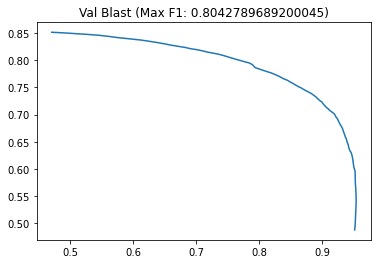

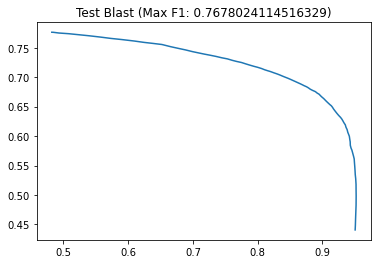

In [44]:
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support

def threshold_stats(testing_matrix, prediction_matrix):
    precs = []
    recs = []
    f_scores = []
    rms = []
    for threshold in np.linspace(0.001, 1, 100):
        preds = prediction_matrix.copy()
        preds.data = np.where(preds.data >= threshold, 1, 0)
        preds.eliminate_zeros()
        p, r, f, support = precision_recall_fscore_support(testing_matrix, preds, average='micro')
        precs.append(p)
        recs.append(r)
        f_scores.append(f)
        rms.append(r*r * preds.shape[0] * preds.shape[1] / preds.sum())
    return precs, recs, f_scores, rms

precs, recs, f_scores, rms = threshold_stats(val_labels, val_blast_preds_matrix)
plt.plot(precs, recs)
plt.title(f"Val Blast (Max F1: {max(f_scores)})")
plt.show()

precs, recs, f_scores, rms = threshold_stats(test_labels, test_blast_preds_matrix)
plt.plot(precs, recs)
plt.title(f"Test Blast (Max F1: {max(f_scores)})")
plt.show()

In [28]:
print(max(f_scores))
print(f_scores[50])

0.8042789689200045
0.8040464666651477


17304 14.126444752658346


In [47]:
import pandas as pd
val_hits = pd.read_csv("../data/blast_results/blast_hit_val.tsv", sep='\t', names=['Query', 'Hit', 'Score'])
print(len(val_hits['Query']))
print(len(set(val_hits['Query'])))
print(len(val_dict.keys()))
print(len(set(val_hits['Query']).intersection(val_hits['Hit'])))
print(len(set(val_hits['Hit']).intersection(train_dict.keys())))

209385
14892
16936
0
48126
